# Importing packages

In [29]:
import os
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFE, RFECV, SequentialFeatureSelector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer, roc_auc_score, f1_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.svm import SVC, SVR

%matplotlib inline

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Load data 

In [30]:
df = pd.read_csv("data/tweets.csv", usecols=["keyword", "text", "target", "location"])
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 2)
train_df

,keyword,location,text,target
3289,debris,NaN,"Unfortunately, both plans fail as the 3 are im...",0
2672,crash,SLC,I hope this causes Bernie to crash and bern. S...,0
2436,collide,NaN,—pushes himself up from the chair beneath to r...,0
9622,suicide%20bomb,NaN,Widow of CIA agent killed in 2009 Afghanistan ...,1
8999,screaming,Azania,As soon as God say yes they'll be screaming we...,0
...,...,...,...,...
1099,blight,NaN,Sounds like a simple and elegant solution to m...,0
2514,collided,she/her 🌈,!!! 2013/14 YOUTUBE COVER LISTENING WORLDS AND...,0
6637,hostages,"Dallas, TX","World! We, Iranians, are hostages of this terr...",0
2575,collision,Greater Manchester,Two of three lanes blocked on the M66 Southbou...,1


# Word cloud

In [31]:
text_combined = " ".join(i for i in df.text)
print ("There are {} words in the combination of all review.".format(len(text_combined)))

There are 1234462 words in the combination of all review.


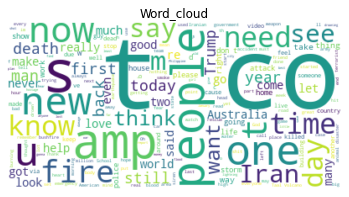

In [32]:
stopwords = set(STOPWORDS)
stopwords.update(["https", 'will', 'tweets'])

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_combined)      # Generate a word cloud image

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word_cloud')
plt.show()

In [42]:
wordcloud.to_file("img/word_cloud.png")

In [33]:
X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]

In [34]:
train_df['target'].value_counts(normalize=True)

0    0.812995
1    0.187005
Name: target, dtype: float64

Since the number of positive instances (ground-truth disasters) are much less than negative instances, we have a class imbalance. It is also clear from the histogram below. I will use "class_weight" argument later to deal with this class imbalance. 

<AxesSubplot:>

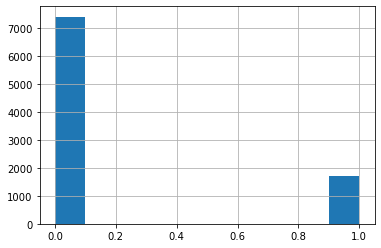

In [37]:
train_df['target'].hist()

In [35]:
# Defining scoring metrics
scoring_metrics = ["f1","roc_auc"]

# Preprocessing

In [38]:
categorical_features = ['keyword']
dropped_features = ['location'] # I am dropping this feature as it has too many NaN or unique values. 
text_features = 'text'

In [39]:
preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_features),
    ("drop", dropped_features),
    (CountVectorizer(stop_words = 'english'), text_features)
)

In [40]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

# Logistic Regression pipeline

In [41]:
results = {}
pipe_lr = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter = 2000)
)

* Cross validation with 5-fold:

In [45]:
results['Logistic Regression'] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, cv = 5, return_train_score=True, scoring = scoring_metrics
)
pd.DataFrame(results)

,Logistic Regression
fit_time,0.405 (+/- 0.042)
score_time,0.106 (+/- 0.024)
test_f1,0.628 (+/- 0.026)
train_f1,0.962 (+/- 0.002)
test_roc_auc,0.898 (+/- 0.011)
train_roc_auc,0.999 (+/- 0.000)


* Hyperparameter tunning:

In [46]:
param_grid = {
    "logisticregression__C": np.logspace(-3, 2, 6),
    "logisticregression__class_weight": [None, 'balanced'],
    "columntransformer__countvectorizer__max_features": [5000, 10000, 15000, 20000] 
}

In [47]:
random_search = RandomizedSearchCV(
    pipe_lr,
    param_distributions=param_grid,
    n_jobs=-1,
    n_iter=10,
    scoring = 'f1',
    cv=5,
    random_state = 123,
    verbose=False
)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['keyword']),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['location']),
                                                                              ('countvectorizer',
                                                                               CountVectorizer(stop_words='english'),
         

In [48]:
random_search.best_params_

{'logisticregression__class_weight': 'balanced',
 'logisticregression__C': 1.0,
 'columntransformer__countvectorizer__max_features': 15000}

In [49]:
random_search.best_score_

0.6696374951965343

# Feature engineering